In [1]:
import pandas as pd
import glob

import os
from skimage import io, measure, morphology, color, filters, transform
import numpy as np

from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm


import porespy as ps

from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.signal import find_peaks
import more_itertools as mit

import urllib
# import torch
import numba

C:\anaconda3\envs\torch\lib\site-packages\openpnm\algorithms\_invasion_percolation.py:358: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _find_trapped_pores(inv_seq, indices, indptr, outlets):  # pragma: no cover


In [2]:
def rgb2smyk(bgr):
    bgrdash = bgr.astype(np.float32)/255.

    # Calculate K as (1 - whatever is biggest out of Rdash, Gdash, Bdash)
    K = 1 - np.max(bgrdash, axis=2)

    # Calculate C
    C = (1-bgrdash[...,2] - K)/(1-K)

    # Calculate M
    M = (1-bgrdash[...,1] - K)/(1-K)

    # Calculate Y
    Y = (1-bgrdash[...,0] - K)/(1-K)

    K*=255
    K=K.astype(np.uint8)

    C*=255
    C=C.astype(np.uint8)

    M*=255
    M=M.astype(np.uint8)

    Y*=255
    Y=Y.astype(np.uint8)

    return C,M,Y,K

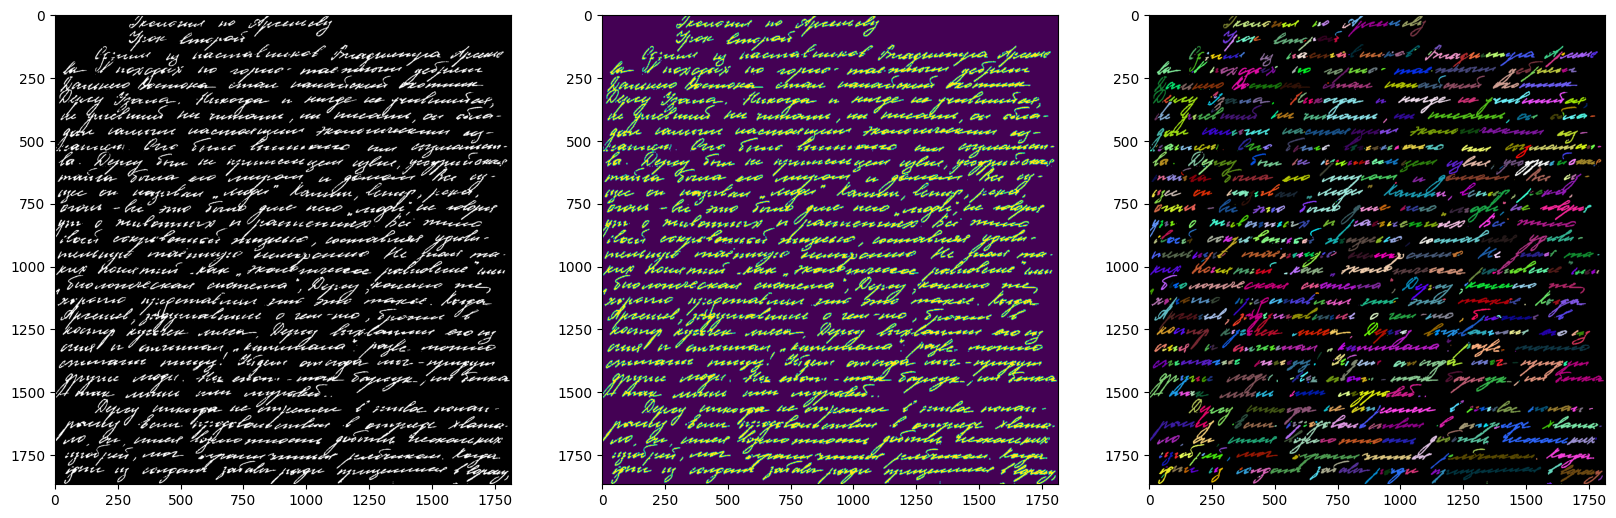

In [3]:
# name='62263_1.jpg'
name='00200_163.jpg'

img=io.imread(name)

# for k in range(N_lines):


(C, M, Y, K) = rgb2smyk(img)

thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# thresh=threshold_otsu(Y)
thresh*=0.8
binaryImage=Y>thresh

binaryImage=binaryImage*255
binaryImage=binaryImage.astype(np.uint8)

# binaryImage=morphology.binary_dilation(binaryImage, morphology.disk(1))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(1, 3))

dilated_image = cv2.dilate(binaryImage, kernel)

labeled_image = measure.label(dilated_image)

labels=np.sort(np.unique(labeled_image))
colors=[[np.random.uniform(0,255),np.random.uniform(0,255),np.random.uniform(0,255)] for label in labels]

colored_img=np.zeros((img.shape[0],img.shape[1],3))
for i,line in enumerate(labeled_image):
    for j,label in enumerate(line):
        if label!=0:
            colored_img[i,j]=colors[label]

colored_img=np.array(colored_img,dtype=np.uint8)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
ax1.imshow(binaryImage, cmap='gray')
ax2.imshow(dilated_image)
ax3.imshow(colored_img)
plt.show()

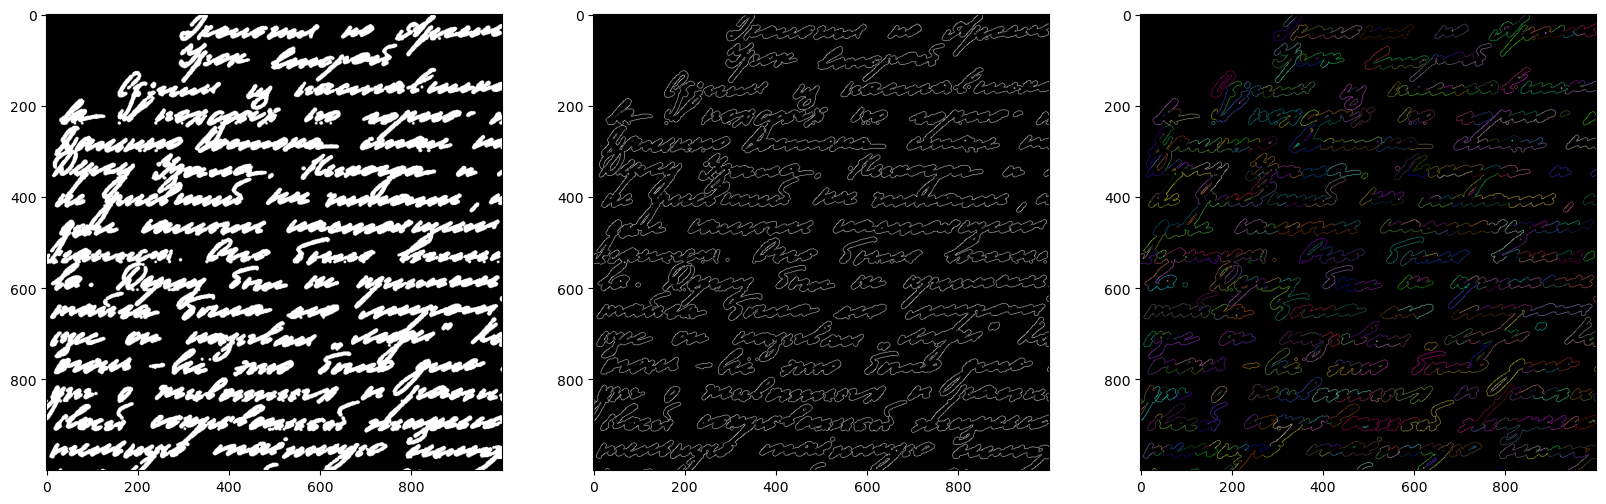

In [7]:
# name='62263_1.jpg'
name='00200_163.jpg'
img=io.imread(name)

(C, M, Y, K) = rgb2smyk(img)

thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

thresh*=0.8
binaryImage=Y>thresh

dilated_image=morphology.binary_dilation(binaryImage, morphology.disk(3))

dilated_image=dilated_image*255
dilated_image=dilated_image.astype(np.uint8)


edges = cv2.Canny(dilated_image, 0, 255, L2gradient=False)

# направление обхода контура по часовой стрелке
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
new_contours = []
for cnt in contours:
    new_contours.append(np.array(cnt).reshape((-1, 2)))

labeled_image = measure.label(edges)

labels=np.sort(np.unique(labeled_image))
colors=[[np.random.uniform(0,255),np.random.uniform(0,255),np.random.uniform(0,255)] for label in labels]

colored_img=np.zeros((img.shape[0],img.shape[1],3))
for i,line in enumerate(labeled_image):
    for j,label in enumerate(line):
        if label!=0:
            colored_img[i,j]=colors[label]

colored_img=np.array(colored_img,dtype=np.uint8)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
ax1.imshow(dilated_image[:1000,:1000], cmap='gray')
ax2.imshow(edges[:1000,:1000], cmap='gray')
ax3.imshow(colored_img[:1000,:1000])
plt.show()

## Space length between words (done)

In [5]:
def lines_location(img):
    mean_pixel_column=[]
    for i in range(img.shape[0]):
        mean_pixel_column.append(np.mean(img[i,:]))

    mean_pixel_column=np.array(mean_pixel_column)*1e3

    fit = SimpleExpSmoothing(mean_pixel_column).fit(smoothing_level=0.1,optimized=False).fittedvalues

    peaks_max=find_peaks(fit,distance=50)[0]
    # shift=peaks_max[0]
    # peaks_min=find_peaks(-fit[shift:],distance=50)[0]
    #
    # peaks_min=np.append(peaks_min, img.shape[0]-1)
    # print(peaks_max.shape)
    # print(peaks_min.shape)

    # return np.vstack([peaks_max,peaks_min]).T
    # return peaks_max, peaks_min+shift, fit
    return peaks_max, fit

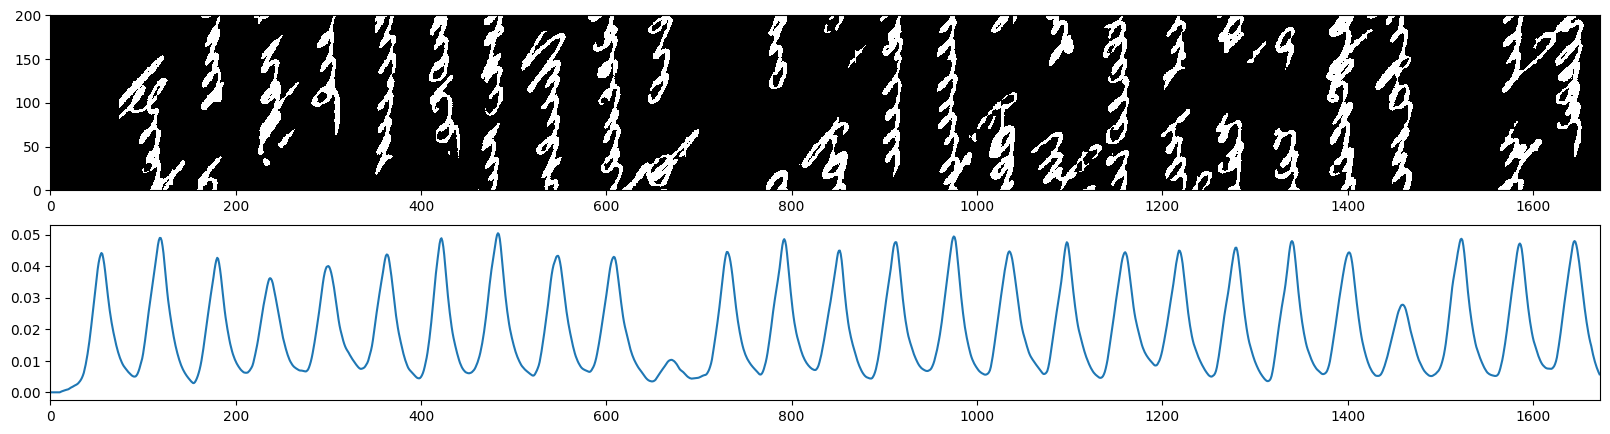

In [11]:
# ровный
# name='00201_73.jpg'

# вправо сильно
name='images/67205_3.jpg'

#  ровный
# name='images/62325_1_12.jpg'

# наклон вправо
# name='67205_2.jpg'

img=io.imread(name)

(C, M, Y, K) = rgb2smyk(img)

thresh=filters.threshold_otsu(Y)
binaryImage=Y>thresh*0.7
boundary=10

img_tmp=np.zeros((img.shape[0]+boundary*2,img.shape[1]+boundary*2),dtype=bool)
img_tmp[boundary:boundary+img.shape[0],boundary:boundary+img.shape[1]]=binaryImage

# lines_loc=lines_location(binaryImage)
peaks_max,fit=lines_location(img_tmp)

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(20,5))

ax1.pcolor(transform.rotate(img_tmp,90)[200:400],cmap='gray')
ax1.set_xlim(0,binaryImage.shape[0]+boundary*2)

ax2.plot(fit/(8*1e3))
# ax2.vlines(peaks_max,ymin=0, ymax=1, color='orange')
# ax2.vlines(peaks_min,ymin=0, ymax=0.5,color='red')
ax2.set_xlim(0,binaryImage.shape[0]+boundary*2)

plt.show()

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [6]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [6]:
# @numba.jit(nopython=True)
def locate_words(img, N=5, min_val=0.01):
    mean_pixel_column=[0]*N
    for i in range(img.shape[1])[N:-N]:
        mean_pixel_column.append(np.mean(img[:,i-N:i+N]))

    mean_pixel_column.extend([0]*N)

    fit = SimpleExpSmoothing(mean_pixel_column).fit(smoothing_level=0.3,optimized=False).fittedvalues
    # fit = moving_average(mean_pixel_column, 5)

    # ret = np.cumsum(mean_pixel_column, dtype=float)
    # ret[N:] = ret[N:] - ret[:-N]
    # fit=ret[N - 1:] / N

    condition = fit < min_val
    words_indices=np.array([np.array(tuple(group))[[0,-1]] for group in mit.consecutive_groups(np.argwhere(condition).flatten())]).flatten()
    words_indices=words_indices[2:-2]

    return words_indices.reshape((-1,2)), fit

(0.0, 1800.0)

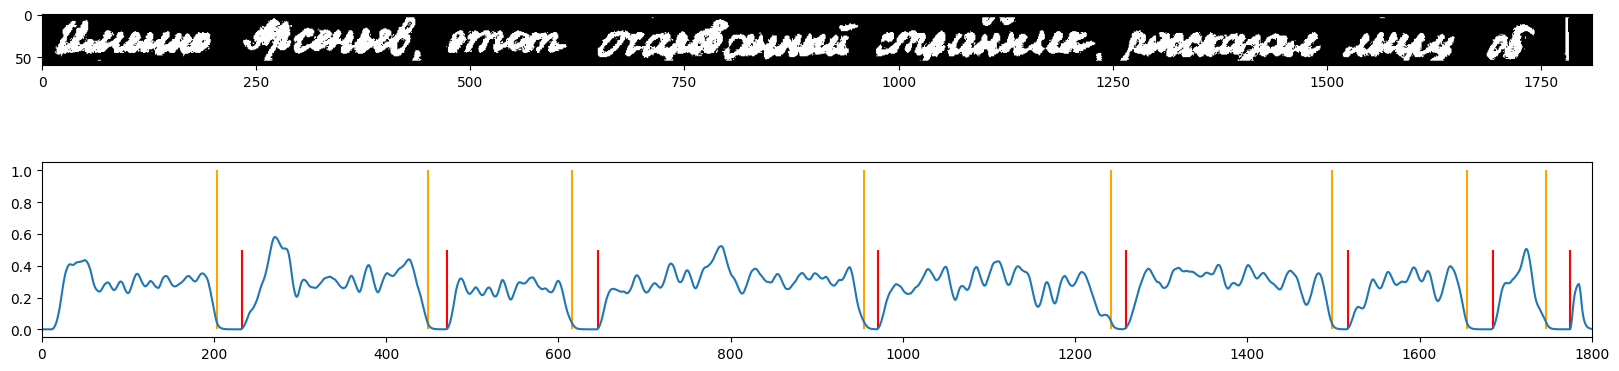

In [7]:
# ровный problem
# name='00201_73.jpg'

# вправо сильно
# name='67205_3.jpg'

#  ровный problem
# name='62325_1_12.jpg'

# наклон вправо
name='67205_2.jpg'

img=io.imread(name)

k=6

xshift=-20
yshift=10
boundary=5

(C, M, Y, K) = rgb2smyk(img)

thresh=filters.threshold_otsu(Y)
binaryImage=Y>thresh*0.3

lines_max, _=lines_location(binaryImage)

img=binaryImage[lines_max[k]-xshift:lines_max[k+1]+yshift,:]

img_tmp=np.zeros((img.shape[0]+boundary*2,img.shape[1]+boundary*2),dtype=bool)
img_tmp[boundary:boundary+img.shape[0],boundary:boundary+img.shape[1]]=img
words_indices,fit=locate_words(img_tmp,N=5)

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(20,5))

ax1.imshow(img_tmp,cmap='gray')
# ax1.set_xlim(0,img.shape[1])

ax2.vlines(words_indices[:,0]-5,ymin=0, ymax=1, color='orange')
ax2.vlines(words_indices[:,1],ymin=0, ymax=0.5,color='red')
ax2.plot(fit)
ax2.set_xlim(0,img.shape[1])

In [14]:
xshift=-20
yshift=10

boundary=5

df=pd.read_csv('grades.csv')

recs={'msk22':[[904,2610],[36, 1838]],
      'msk23':[[886,2621],[44, 1824]],
      'nov23':[[876,2590],[41, 1834]],}


length_std=[]
length_mean=[]

for i in tqdm(range(len(df))):
    id=df.iloc[i]['id']
    type=df.iloc[i]['type']
    rec=recs[type]
    img=io.imread(f'data/{type}/blanks_aligned_jpg/{id}.jpg')[rec[0][0]:rec[0][1],rec[1][0]:rec[1][1]]

    (C, M, Y, K) = rgb2smyk(img)

    thresh=filters.threshold_otsu(Y)
    binaryImage=Y>thresh*0.7

    lines_max, _=lines_location(binaryImage)
    length=[]
    for k in range(len(lines_max))[:-1]:
        img=binaryImage[lines_max[k]-xshift:lines_max[k+1]+yshift,:]

        img_tmp=np.zeros((img.shape[0]+boundary*2,img.shape[1]+boundary*2),dtype=bool)
        img_tmp[boundary:boundary+img.shape[0],boundary:boundary+img.shape[1]]=img
        words_indices,_=locate_words(img_tmp,N=3)
        length.extend(np.diff(words_indices,axis=1)+5)

    length_mean.append(np.mean(length))
    length_std.append(np.std(length))
    
    if i%10==0:
        np.save('length_mean.npy',length_mean)
        np.save('length_std.npy',length_std)

  0%|          | 0/21308 [00:00<?, ?it/s]

C:\anaconda3\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\anaconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [15]:
df['space_length_std']=length_std
df['space_length_mean']=length_mean

df.to_csv('grades_space_length.csv',index=False)